# Evaluation 4DVARNET: 

This notebook presents the evaluation of the SSH reconstructions based on the 4DVarNet approach ([R Fablet et al.,2021](https://hal.archives-ouvertes.fr/hal-03189218)) and performed for the **"
2020a_SSH_mapping_NATL60" ocean data challenge**.

Two experiments are analysed:
>   A) **Experiment 1**: The results that will be presented correspond to the case where the model is first trained with data of the north Atlantic basin, then the data of the Gulfstream(GF) region.

>   B) **Experiment 2**: Training data: Gulfstream2 ; Test data: GF

 The evaluations are based on the methods & metrics described in the "example_data_eval.ipynb" notebook

In [24]:
import xarray as xr
import numpy
import hvplot.xarray
import pyinterp
import dask
import warnings
import xrft
import os
import sys
import pandas as pd
import logging
warnings.filterwarnings('ignore')

In [25]:
!which python 

/linkhome/rech/genlst01/ueh53pd/.conda/envs/notebooks/bin/python


##### libraries versions

In [26]:
print('xarray', xr.__version__)
print('numpy', numpy.__version__)
print('hvplot', hvplot.__version__)
print('pyinterp', pyinterp.__version__)
print('dask', dask.__version__)
print('logging', logging.__version__)
print('xrft', xrft.__version__)

xarray 0.19.0
numpy 1.21.2
hvplot 0.7.3
pyinterp 0.8.1
dask 2021.09.1
logging 0.5.1.2
xrft unknown


In [27]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [28]:
sys.path.append('..')

In [29]:
from src.mod_oi import *
from src.mod_inout import *
from src.mod_regrid import *
from src.mod_eval import *
from src.mod_plot import *

##### Read Nature run SSH for mapping evaluation

In [30]:
data_directory = '../data/'
if not os.path.exists(data_directory):
    os.mkdir(data_directory) 

In [31]:
!wget --directory-prefix=../data https://store3.gofile.io/download/7c2b3332-f46c-4901-9a09-b141d62cd4e4/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_gt.nc

/bin/bash: wget: command not found


In [32]:
dc_ref = xr.open_dataset('../data/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_gt.nc')
dc_ref

<xarray.Dataset>
Dimensions:   (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon       (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat       (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time      (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    sossheig  (time, lat, lon) float32 ...

In [33]:
# Domain for analysis: Gulfstream
time_min = numpy.datetime64('2012-10-22')                # domain min time
time_max = numpy.datetime64('2012-12-02')                # domain max time
lon_min = -64.975                                        # domain min lon
lon_max = -55.007                                        # domain max lon
lat_min = 33.025                                         # domain min lat
lat_max = 42.9917                                        # domain max lat

##### Select time window sample for evaluation 

In [34]:
dc_ref_sample = dc_ref.sel(time=slice(time_min, time_max), 
                           lon=slice(lon_min, lon_max), 
                           lat=slice(lat_min, lat_max))
del dc_ref
dc_ref_sample

<xarray.Dataset>
Dimensions:   (time: 42, lat: 199, lon: 199)
Coordinates:
  * lon       (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.15 -55.1 -55.05
  * lat       (lat) float64 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time      (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    sossheig  (time, lat, lon) float32 ...

#### - Evalutation 4DVarNet NATL Fine Tuning (Experience 1) 

In [35]:
!wget --directory-prefix=../data https://store3.gofile.io/download/65078c91-55b8-4963-b89e-dac8e7cfc02f/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_FineTuning.nc

/bin/bash: wget: command not found


In [36]:
# Read 4DVarNet SSH reconstruction
ds_oi1_grid = xr.open_dataset('../data/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_FineTuning.nc')
ds_oi1_grid

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    gssh     (time, lat, lon) float32 ...

In [37]:
output_directory = '../results/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory) 

In [38]:
%%time
# Regrid    
ds_oi1_regrid = oi_regrid(ds_oi1_grid, dc_ref_sample)
print(ds_oi1_grid.info())
# Eval
rmse_t_oi1, rmse_xy_oi1, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_oi1_regrid, dc_ref_sample)
psd_oi1, leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(ds_oi1_regrid, dc_ref_sample)

filename_rmse_t = output_directory + 'rmse_t_bfn_ssh_reconstruction_2012-10-22-2012-12-02_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_rmse_xy = output_directory + 'rmse_xy_bfn_ssh_reconstruction_2012-10-22-2012-12-02_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_psd = output_directory + 'psd_bfn_ssh_reconstruction_2012-10-22-2012-12-02_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_dc_ref_sample = output_directory + 'dc_ref_2012-10-22-2012-12-02_sample.nc'
filename_oi_regrid = output_directory + 'bfn_ssh_reconstruction_regridded_2012-10-22-2012-12-02_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
# Save results
rmse_t_oi1.to_netcdf(filename_rmse_t)
rmse_xy_oi1.to_netcdf(filename_rmse_xy)

psd_oi1.name = 'psd_score'
psd_oi1.to_netcdf(filename_psd)
dc_ref_sample.to_netcdf(filename_dc_ref_sample)
ds_oi1_regrid.to_netcdf(filename_oi_regrid)
# Print leaderboard
data = [['bfn 4 nadirs', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         leaderboard_psds_score, 
         leaderboard_psdt_score,
        'xxxxxx',
        'eval_4dvarnet.ipynb']]

Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (degree)', 
                                    'λt (days)', 
                                    'Notes',
                                    'Reference'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())

INFO:root:     Regridding...
INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.95
INFO:root:          Error variability = 0.01 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


xarray.Dataset {
dimensions:
	time = 42 ;
	lat = 200 ;
	lon = 200 ;

variables:
	float32 gssh(time, lat, lon) ;
	float64 lon(lon) ;
	float64 lat(lat) ;
	datetime64[ns] time(time) ;

// global attributes:
}None
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s


INFO:root:          => Leaderboard Spectral score = 0.92 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 6.48 (days)


Summary of the leaderboard metrics:
|    | Method       |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Notes   | Reference           |
|---:|:-------------|-----------:|----------:|--------------:|------------:|:--------|:--------------------|
|  0 | bfn 4 nadirs |       0.95 |      0.01 |          0.92 |        6.48 | xxxxxx  | eval_4dvarnet.ipynb |
CPU times: user 2.42 s, sys: 360 ms, total: 2.78 s
Wall time: 2.24 s


#### - Evaluation 4DVARNET GF2/GF (Experience 2)

In [39]:
!wget --directory-prefix=../data https://store3.gofile.io/download/e1f81597-4430-4077-8dbf-a0fab20b9029/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_GF2_GF.nc

/bin/bash: wget: command not found


In [40]:
ds_oi2_grid = xr.open_dataset('../data/2021a_SSH_mapping_NATL60_4DVarNet_nadirswot_GF2_GF.nc')
ds_oi2_grid

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    gssh     (time, lat, lon) float32 ...

In [41]:
output_directory = '../results/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory) 

In [42]:
%%time
# Regrid    
ds_oi2_regrid = oi_regrid(ds_oi2_grid, dc_ref_sample)
# Eval
rmse_t_oi2, rmse_xy_oi2, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_oi2_regrid, dc_ref_sample)
psd_oi2, leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(ds_oi2_regrid, dc_ref_sample)
filename_rmse_t = output_directory + 'rmse_t_bfn_ssh_reconstruction_2012-10-22-2012-12-02_swot_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_rmse_xy = output_directory + 'rmse_xy_bfn_ssh_reconstruction_2012-10-22-2012-12-02_swot_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_psd = output_directory + 'psd_bfn_ssh_reconstruction_2012-10-22-2012-12-02_swot_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
filename_dc_ref_sample = output_directory + 'dc_ref_2012-10-22-2012-12-02_sample.nc'
filename_oi_regrid = output_directory + 'bfn_ssh_reconstruction_regridded_2012-10-22-2012-12-02_swot_jason1_topex-poseidon_interleaved_envisat_geosat2.nc'
# Save results
rmse_t_oi2.to_netcdf(filename_rmse_t)
rmse_xy_oi2.to_netcdf(filename_rmse_xy)
psd_oi2.name = 'psd_score'
psd_oi2.to_netcdf(filename_psd)
dc_ref_sample.to_netcdf(filename_dc_ref_sample)
ds_oi2_regrid.to_netcdf(filename_oi_regrid)
# Print leaderboard
data = [['bfn 1 swot + 4 nadirs', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         leaderboard_psds_score, 
         leaderboard_psdt_score,
        'QG Nudging',
        'eval_bfn.ipynb']]
Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (degree)', 
                                    'λt (days)', 
                                    'Notes',
                                    'Reference'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())

INFO:root:     Regridding...
INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.94
INFO:root:          Error variability = 0.01 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.9s


INFO:root:          => Leaderboard Spectral score = 0.95 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 7.89 (days)


Summary of the leaderboard metrics:
|    | Method                |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Notes      | Reference      |
|---:|:----------------------|-----------:|----------:|--------------:|------------:|:-----------|:---------------|
|  0 | bfn 1 swot + 4 nadirs |       0.94 |      0.01 |          0.95 |        7.89 | QG Nudging | eval_bfn.ipynb |
CPU times: user 2.42 s, sys: 341 ms, total: 2.76 s
Wall time: 2.14 s


#### - PLOT EVALUATION SCORES

In [43]:
rmse_concat = xr.concat((rmse_t_oi1, rmse_t_oi2), dim='experiment')
rmse_concat['experiment'] = ["NATL Fine Tuning", "GF2/GF"]
rmse_concat.hvplot.line(x='time', y='rmse_t', by='experiment', ylim=(0, 1), cmap=['royalblue', 'lightcoral'], title='RMSE-based scores')

:NdOverlay   [experiment]
   :Curve   [time]   (rmse_t)

In [44]:
rmse_xy_concat = xr.concat((rmse_xy_oi1, rmse_xy_oi2), dim='experiment')
rmse_xy_concat['experiment'] = ["NATL Fine Tuning", "GF2/GF"]
rmse_xy_concat.hvplot.contourf(x='lon', y='lat', levels=list(numpy.arange(0.,0.75, 0.05)), height=300, width=400, cmap='Reds', subplots=True, by='experiment', clabel='RMSE[m]')

:NdLayout   [experiment]
   :Polygons   [lon,lat]   (rmse_xy)

In [45]:
psd_concat = xr.concat((psd_oi1, psd_oi2), dim='experiment')
psd_concat['experiment'] = ["NATL Fine Tuning", "GF2/GF"]

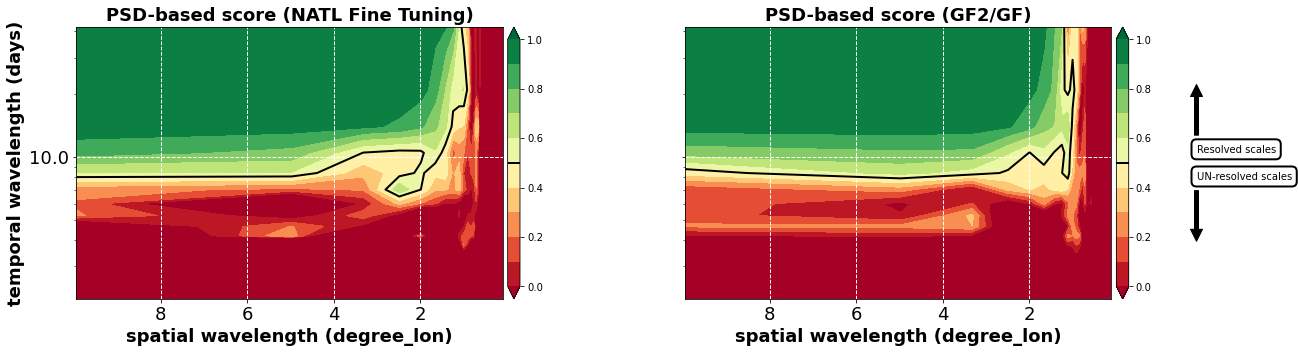

In [46]:
plot_psd_score_v0(psd_concat)